In [1]:
import sys
sys.path.append("../src")

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re


from news_headlines import RAW_DIR, preprocess_news, clean_headlines, flag_sectors


In [2]:
csv_files = list(RAW_DIR.glob("*_headlines.csv"))
csv_files

outputs = [preprocess_news(path) for path in csv_files]

## Merging the datasets

In [3]:
paths_to_data = [
    Path("../data/preprocessed/headlines/cnbc_preprocessed.csv"),
    Path("../data/preprocessed/headlines/guardian_preprocessed.csv"),
    Path("../data/preprocessed/headlines/reuters_preprocessed.csv")
]

dfs = []

for path in paths_to_data:
    df = pd.read_csv(path, encoding="utf-8")
    dfs.append(df)

news_df = pd.concat(dfs, ignore_index=True)
news_df.head(10)

,Date,Headlines,Newspaper
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc
1,2018-03-20,Cramer's charts show 'signs of life' for the s...,cnbc
2,2018-03-20,Information is 'the modern-day weapon' and we'...,cnbc
3,2018-03-20,Cramer's lightning round: With so many great b...,cnbc
4,2018-03-20,Cramer Remix: Here's how Mark Zuckerberg shoul...,cnbc
5,2018-03-21,Cramer Remix: Goldman Sachs is the ideal stock...,cnbc
6,2018-03-21,Cramer: What FedEx's earnings call reveals abo...,cnbc
7,2018-03-21,Cramer's lightning round: Watch the technicals...,cnbc
8,2018-03-21,Cramer: Facebook's troubles shouldn't weigh on...,cnbc
9,2018-03-21,Cramer highlights the value of McDonald's: The...,cnbc


### Checking for missing values, duplicates

In [4]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51122 entries, 0 to 51121
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       51122 non-null  object
 1   Headlines  51122 non-null  object
 2   Newspaper  51122 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


#### Sort headlines by date

Date is an object (string), so we need to correct it into datetime

In [5]:
news_df["Date"] = pd.to_datetime(news_df["Date"])
news_df.info()
news_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51122 entries, 0 to 51121
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       51122 non-null  datetime64[ns]
 1   Headlines  51122 non-null  object        
 2   Newspaper  51122 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.2+ MB


,Date,Headlines,Newspaper
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc
1,2018-03-20,Cramer's charts show 'signs of life' for the s...,cnbc
2,2018-03-20,Information is 'the modern-day weapon' and we'...,cnbc
3,2018-03-20,Cramer's lightning round: With so many great b...,cnbc
4,2018-03-20,Cramer Remix: Here's how Mark Zuckerberg shoul...,cnbc


##### It may not look like it, but we need to sort the dataset by date because it's now sorted by the order we joined the separate newspaper datasets in.

In [6]:
news_df = news_df.sort_values("Date", ascending=True).reset_index(drop=True)

In [7]:
news_df.head(10)

,Date,Headlines,Newspaper
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc
1,2018-03-20,G20 financial leaders say need more dialogue o...,reuters
2,2018-03-20,Index provider MSCI says it is reviewing Faceb...,reuters
3,2018-03-20,UK's Cambridge University questions Facebook a...,reuters
4,2018-03-20,"Exclusive: On Amazon, a quarter of merchants' ...",reuters
5,2018-03-20,IMF's Lagarde urges G20 to avoid 'exceptional'...,reuters
6,2018-03-20,Tesla denies Musk in talks with Israeli AI vis...,reuters
7,2018-03-20,General Dynamics raises bid for sector peer CS...,reuters
8,2018-03-20,Exclusive: Salesforce in advanced talks to buy...,reuters
9,2018-03-20,Toys 'R' Us says 'making every effort' to pay ...,reuters


In [8]:
news_df.describe()

,Date
count,51122
mean,2019-06-04 07:56:29.304017920
min,2018-03-20 00:00:00
25%,2018-10-31 00:00:00
50%,2019-06-08 00:00:00
75%,2020-01-21 00:00:00
max,2020-07-17 00:00:00


In [9]:
news_df.isna().sum()

Date         0
Headlines    0
Newspaper    0
dtype: int64

In [10]:
news_df.duplicated(subset=["Date", "Headlines"]).sum()



80

In [11]:
news_df.drop_duplicates()


,Date,Headlines,Newspaper
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc
1,2018-03-20,G20 financial leaders say need more dialogue o...,reuters
2,2018-03-20,Index provider MSCI says it is reviewing Faceb...,reuters
3,2018-03-20,UK's Cambridge University questions Facebook a...,reuters
4,2018-03-20,"Exclusive: On Amazon, a quarter of merchants' ...",reuters
...,...,...,...
51117,2020-07-17,I flew the jumbo for 10 years and never got ov...,guardian
51118,2020-07-17,BA begins to carry out its 'fire and rehire' t...,guardian
51119,2020-07-17,Johnson's coronavirus workplace guidance confu...,guardian
51120,2020-07-17,Wall Street Week Ahead: Fund managers navigate...,reuters


#### FinBERT is a transformer model trained on finance text, it can handle casing, subword tokenization, punctuation on its own, so I will not do the typical text cleaning steps like converting all text to lowercase. I'm trying not to clean the data too much, so we don't lose important information.

In [12]:
# looking for non-ASCII characters
mask_nonascii = news_df["Headlines"].str.contains(r"[^\x00-\x7F]")
news_df.loc[mask_nonascii, "Headlines"].head(10)


19     Scrapping EU tariffs would do little to cut UK...
22     UK drivers to save £35 after new curbs on whip...
25     UK inflation is falling fast – that's good and...
29     Gambling watchdog fails to curb fixed-odds bet...
75     'Beast from the east' knocks £1.5m off Ocado p...
149    PwC charges more than £20m for first eight wee...
150    Lloyd’s of London slides to £2bn loss after ma...
158    Cramer: Facebook's troubles shouldn't weigh on...
164    PwC faces MPs over accusations of ‘milking the...
228    Wanting to escape the office grind doesn’t mak...
Name: Headlines, dtype: object

In [13]:
# looking for zero width characters (or invisible characters)
mask_invisible = news_df["Headlines"].str.contains(r"[\u200B-\u200D\uFEFF\u00A0]")
news_df.loc[mask_invisible, "Headlines"].head(10)


374     Next chief calls 2017 'toughest in 25 years' a...
411     Project Syndicate economists  \r\n\r\n\r\n  Th...
567     Berlin declines to comment on reports Deutsche...
579     ​Jaguar to supply 20,000 cars to Google's self...
637     CEO says committed to Deutsche Bank amid repor...
737     Melrose trio who sought biggest deal yet with ...
1078    Clariant expects sales of about $2 billion in ...
1437    Many reasons to be grateful to Bristol’s tobac...
1784    Business live  Britain's cost of living squeez...
2014    Nils Pratley on finance  \r\n\r\n\r\n  Shire s...
Name: Headlines, dtype: object

In [14]:
# checking for double white space
mask_whitespace = news_df["Headlines"].str.contains(r"\s{2,}")
news_df.loc[mask_whitespace, "Headlines"].head(10)


18     Business live  Facebook's value slides by $36b...
21     Business live  UK inflation rate hits seven-mo...
32     Nils Pratley on finance  \r\n\r\n\r\n  Barclay...
33     Business breakthroughs  Waterstones boss James...
142    Brief letters  Bring your brolly if you come t...
147    Nils Pratley on finance  \r\n\r\n\r\n  Faceboo...
155    Brief letters  Diarrhoea simply cannot be forg...
224    Business live  Global markets hit as Trump unv...
234    Business made simple  Stuck in meetings all da...
235    Nils Pratley on finance  \r\n\r\n\r\n  The UK ...
Name: Headlines, dtype: object

Non-ASCII: 3378 (6.61%)
Invisible chars: 112 (0.22%)
Excess whitespace: 2694 (5.27%)


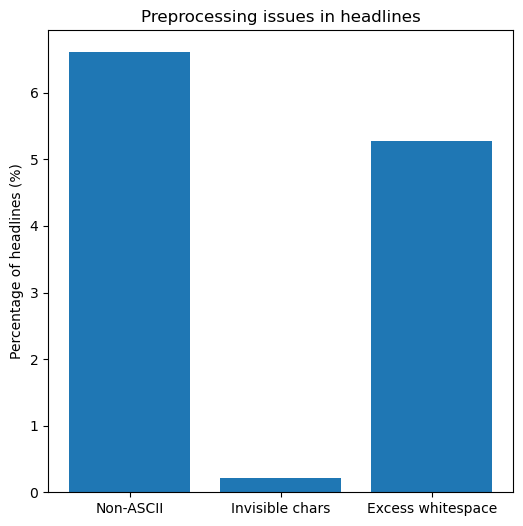

In [15]:
issues = {
    "Non-ASCII": mask_nonascii,
    "Invisible chars": mask_invisible,
    "Excess whitespace": mask_whitespace
}

labels = []
percentages = []

for name, mask in issues.items():
    count_issues = mask.sum()
    percent = count_issues / (len(news_df)) * 100
    print(f"{name}: {count_issues} ({percent:.2f}%)")
    labels.append(name)
    percentages.append(percent)

plt.figure(figsize=(6, 6))
plt.bar(labels, percentages)
plt.ylabel("Percentage of headlines (%)")
plt.title("Preprocessing issues in headlines")
plt.show()


In [16]:
news_df["Headlines"] = clean_headlines(news_df["Headlines"])

In [17]:
mask_nonascii1   = news_df["Headlines"].str.contains(r"[^\x00-\x7F]", na=False)
mask_invisible1  = news_df["Headlines"].str.contains(r"[\u200B-\u200D\u2060\uFEFF\u00A0]", na=False)
mask_whitespace1 = news_df["Headlines"].str.contains(r"\s{2,}", na=False)


Non-ASCII: 3310 (6.47%)
Invisible chars: 0 (0.00%)
Excess whitespace: 0 (0.00%)


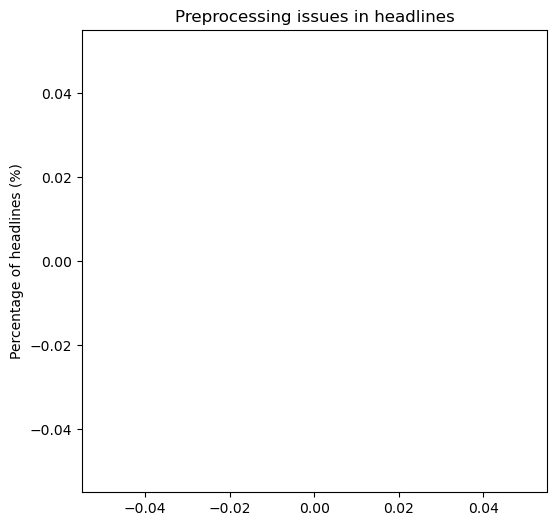

In [18]:
issues1 = {
    "Non-ASCII": mask_nonascii1,
    "Invisible chars": mask_invisible1,
    "Excess whitespace": mask_whitespace1
}

labels1 = []
percentages1 = []

for name1, mask1 in issues1.items():
    count_issues1 = mask1.sum()
    percent1 = count_issues1 / (len(news_df)) * 100
    print(f"{name1}: {count_issues1} ({percent1:.2f}%)")
    labels.append(name1)
    percentages.append(percent1)

plt.figure(figsize=(6, 6))
plt.bar(labels1, percentages1)
plt.ylabel("Percentage of headlines (%)")
plt.title("Preprocessing issues in headlines")
plt.show()

In [19]:
all_chars = "".join(news_df["Headlines"].dropna().tolist())
nonascii_chars = re.findall(r"[^\x00-\x7F]", all_chars)
Counter(nonascii_chars).most_common(20)


[('’', 1538),
 ('–', 993),
 ('£', 955),
 ('‘', 343),
 ('—', 156),
 ('€', 53),
 ('é', 35),
 ('ó', 6),
 ('á', 3),
 ('ğ', 3),
 ('“', 2),
 ('”', 2),
 ('ë', 2),
 ('à', 2),
 ('́', 2),
 ('⁄', 1),
 ('ü', 1),
 ('æ', 1),
 ('ç', 1),
 ('í', 1)]

#### After .normalize("NFKC") and removing other characters, the only non-ASCII characters that remain are important symbols like currency signs or accented letters. FinBERT's tokenizer shouldn't have issues with these.

#### Now we move on to creating new binary columns for each sector and we'll check if headlines contain the keywords for them

In [20]:
news_df = flag_sectors(news_df)
news_df.head()

,Date,Headlines,Newspaper,XLE,XLF,XLK,XLV,XLY
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc,0,0,1,0,0
1,2018-03-20,G20 financial leaders say need more dialogue o...,reuters,0,0,0,0,0
2,2018-03-20,Index provider MSCI says it is reviewing Faceb...,reuters,0,0,0,0,0
3,2018-03-20,UK's Cambridge University questions Facebook a...,reuters,0,0,0,0,0
4,2018-03-20,"Exclusive: On Amazon, a quarter of merchants' ...",reuters,0,0,0,0,1


In [21]:
news_df[["XLE", "XLF", "XLK", "XLV", "XLY"]].mean().sort_values(ascending=False)


XLY    0.094069
XLF    0.085227
XLV    0.080572
XLK    0.058801
XLE    0.053206
dtype: float64

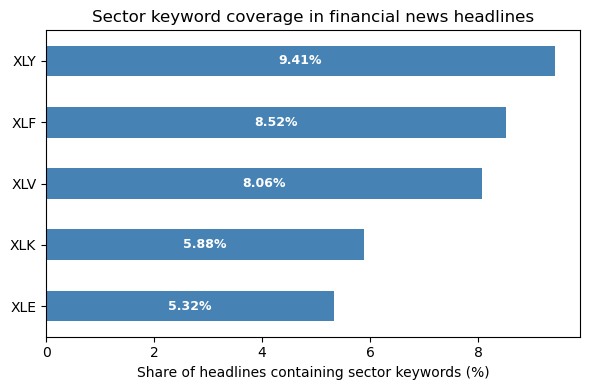

In [22]:
# share of headlines that matched each sector
sector_shares = (news_df[["XLE", "XLF", "XLK", "XLV", "XLY"]].mean() * 100).round(2)
sector_shares_sorted = sector_shares.sort_values()

plt.figure(figsize=(6,4))
ax = sector_shares_sorted.plot(kind="barh", color="steelblue")

plt.xlabel("Share of headlines containing sector keywords (%)")
plt.title("Sector keyword coverage in financial news headlines")

# add labels inside each bar
for i, (sector, v) in enumerate(sector_shares_sorted.items()):
    ax.text(v / 2, i, f"{v:.2f}%", color="white", ha="center", va="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()


In [23]:
sector_cols = ["XLE", "XLF", "XLK", "XLV", "XLY"]

# group by Newspaper and compute mean() (since columns are 0/1)
sector_shares_by_paper = news_df.groupby("Newspaper")[sector_cols].mean() * 100
sector_shares_by_paper = sector_shares_by_paper.round(2)

sector_shares_by_paper


,XLE,XLF,XLK,XLV,XLY
Newspaper,,,,,
cnbc,2.74,5.96,13.31,7.71,10.77
guardian,2.87,7.49,2.32,7.32,8.62
reuters,6.70,9.22,7.03,8.44,9.68


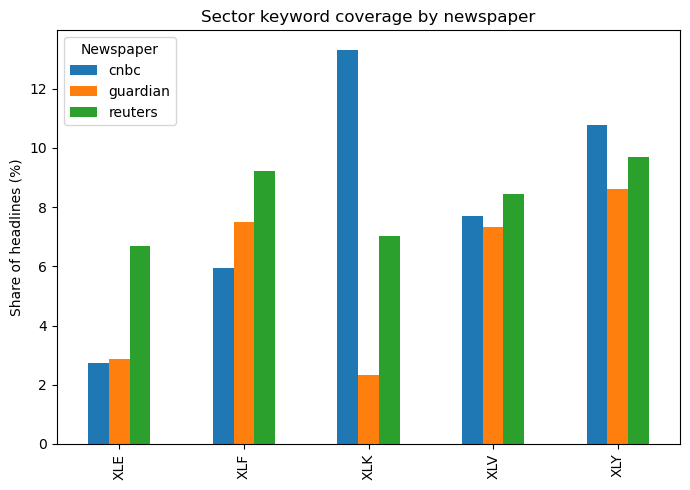

In [24]:
sector_shares_by_paper.T.plot(kind="bar", figsize=(7,5))
plt.ylabel("Share of headlines (%)")
plt.title("Sector keyword coverage by newspaper")
plt.legend(title="Newspaper")
plt.tight_layout()
plt.show()


#### Quick check if the sectors are assigned correctly - in my opinion they are:

In [25]:
sector_cols = ["XLE", "XLF", "XLK", "XLV", "XLY"]

def show_sector_samples(df, sector, n=5, seed=1):
    print(f"\n{sector} (sample of headlines with {sector}=1):")
    matched = df[df[sector] == 1]["Headlines"].sample(n=min(n, len(df[df[sector]==1])), random_state=seed)
    for h in matched:
        print(h)

    print(f"\n{sector} (sample of headlines with {sector}=0):")
    unmatched = df[df[sector] == 0]["Headlines"].sample(n=min(n, len(df[df[sector]==0])), random_state=seed)
    for h in unmatched:
        print(h)

for sector in sector_cols:
    show_sector_samples(news_df, sector, n=5)



XLE (sample of headlines with XLE=1):
Factbox: U.S. prepared to tap emergency oil reserves, Perry says no decision yet
Oil loses about 2% on swelling U.S. stockpiles, demand worries
Saudi Aramco restored oil output to pre-attack level: trading unit chief
Exxon Mobil profit sinks, Chevron rises as both boost output
US push to ease global energy controls as it hands fossil fuels $3bn

XLE (sample of headlines with XLE=0):
France fines Google 150 million euros for opaque advertising rules
Papa John's founder says successor not right fit for CEO
Sony stock surges after Reuters reports Third Point re-building stake
Nils Pratley on finance Why the UK's coronavirus bailout plan isn't working
Quarter of rural businesses 'could be bankrupted by no-deal Brexit'

XLF (sample of headlines with XLF=1):
Commerzbank CEO sees strong investment bank as good fit: source
Trump sues Deutsche Bank and Capital One to block House subpoenas
Deutsche Bank plans job cuts of at least 10% in rates unit: Bloomber

#### Everything looks good to me, so we can move on to Sentiment Analysis with FinBERT

In [26]:
news_df.head()

,Date,Headlines,Newspaper,XLE,XLF,XLK,XLV,XLY
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc,0,0,1,0,0
1,2018-03-20,G20 financial leaders say need more dialogue o...,reuters,0,0,0,0,0
2,2018-03-20,Index provider MSCI says it is reviewing Faceb...,reuters,0,0,0,0,0
3,2018-03-20,UK's Cambridge University questions Facebook a...,reuters,0,0,0,0,0
4,2018-03-20,"Exclusive: On Amazon, a quarter of merchants' ...",reuters,0,0,0,0,1


In [27]:
news_df.to_csv("../data/preprocessed/headlines/headlines.csv", index=False)